<a href="https://colab.research.google.com/github/sachchit-k/NlpProj/blob/main/IntershipStudioProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import string
import re
import numpy 
from numpy import array,argmax,random,take
import pandas as pd
import keras
from keras.models import Sequential


AttributeError: ignored

In [ ]:
from keras.layers import Dense,LSTM,Embedding,Bidirectional,RepeatVector,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt


In [ ]:
% matplotlib inline
pd.set_option('display.max_colwidth',200)

####function for reading the file of eng-deu sentence pairs

In [5]:
def read_text(filename):
  file=open(filename,mode='rt',encoding='utf-8')
  text=file.read()
  file.close()
  return text

####spliting text into sentences

In [6]:
def to_lines(text):
  sents=text.strip().split('\n')
  sents=[i.split('\t')for i in sents]
  return sents


In [7]:
data=read_text('/content/drive/MyDrive/Proj/1.PROJ/InternshipStudio/deu-eng/deu.txt')
deu_eng=to_lines(data)
deu_eng=array(deu_eng)

In [8]:
deu_eng.shape

(248311, 3)

####considering first 50000 sentence pairs only

In [9]:
deu_eng=deu_eng[:50000,:]

In [10]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["Tom isn't my husband.", 'Tom ist nicht mein Ehemann.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056099 (Luiaard)'],
       ["Tom isn't my husband.", 'Tom ist nicht mein Ehegatte.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056100 (Luiaard)'],
       ["Tom isn't my husband.", 'Tom ist nicht mein Gatte.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5938363 (CK) & #8056101 (Luiaard)']],
      dtype='<U537')

####Text to sequence conversion:

In [11]:
#empty lists
eng_l=[]
deu_l=[]

#populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))


In [12]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

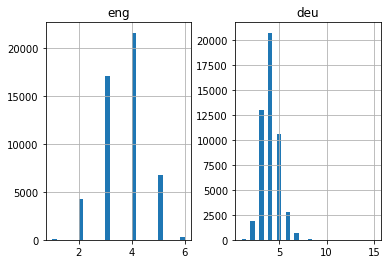

In [13]:
length_df.hist(bins=30)
plt.show()

####Using keras tokenizer sent-->seq of integer
####then we will pad those sequence with zeros to make all the sequcences of same length

In [14]:
#function tp build a tokenizer
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [15]:
#preparing english tokenizer
eng_tokenizer=tokenization(deu_eng[:,0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8

In [16]:
print('English Vocabulary size: %d'% eng_vocab_size)

English Vocabulary size: 6122


In [17]:
#preparing Deutch tokenizer
deu_tokenizer=tokenization(deu_eng[:,1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('Deutch Vocabulary Size: %d' %deu_vocab_size)

Deutch Vocabulary Size: 10076


####function to prepare sequences.also to perform sequence padding

In [18]:
#encoding and pad sequences
def encode_sequences(tokenizer,length,lines):
  #integer encode sequences
  seq=tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq=pad_sequences(seq,maxlen=length,padding='post')
  return seq

####model bulding

In [19]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(deu_eng,test_size=0.2,random_state=12)

####encoding and decoding part


In [20]:
#preparing training data
trainX=encode_sequences(deu_tokenizer,deu_length,train[:,1])
trainY=encode_sequences(eng_tokenizer,eng_length,train[:,0])

In [21]:
#preparing validation data
testX=encode_sequences(deu_tokenizer,deu_length,test[:,1])
testY=encode_sequences(eng_tokenizer,eng_length,test[:,0])

####creating seq to seq model architechtiure
####2 lsmt layer as encoder and decoder

In [22]:
from keras.layers import Embedding, Input
from keras import Model
from tensorflow.keras import optimizers

In [23]:
#built in nmt model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model=Sequential()
  model.add(Embedding(in_vocab,units,input_length=in_timesteps))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab,activation='softmax'))
  return model


####using rmsprop optimizer

In [24]:
model=build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms= optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

# model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
# rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [25]:
filename='model.h1.24_sachchit'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs=5,batch_size=512,
                  validation_split=0.2,
                  callbacks=[checkpoint],verbose=1)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 3.2039
Epoch 00001: val_loss improved from inf to 2.76525, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 30s 323ms/step - loss: 3.2039 - val_loss: 2.7652
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 2.7013
Epoch 00002: val_loss improved from 2.76525 to 2.65506, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 19s 304ms/step - loss: 2.7013 - val_loss: 2.6551
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 2.5488
Epoch 00003: val_loss improved from 2.65506 to 2.53297, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 19s 305ms/step - loss: 2.5488 - val_loss: 2.5330
Epoch 4/5
63/63 [==============================] - ETA: 0s - loss: 2.3930
Epoch 00004: val_loss improved from 2.53297 to 2.41873, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 20s 324ms/step - loss: 2.3930 - val_loss: 2.4187
Epoch 5/5
63/63 [==============================] - ETA: 0s - loss: 2.2633
Epoch 00005: val_loss improved from 2.41873 to 2.29729, saving model to model.h1.24_sachchit


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


INFO:tensorflow:Assets written to: model.h1.24_sachchit/assets


63/63 [==============================] - 19s 302ms/step - loss: 2.2633 - val_loss: 2.2973


####Comparing traing loss and validation loss

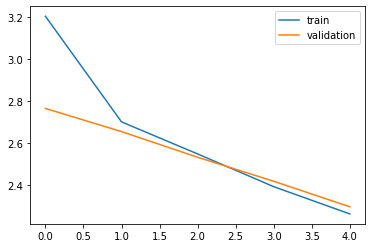

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

####loding the saved model

In [33]:
# import numpy as np

In [ ]:
# !pip install tensorflow==2.5.0


In [77]:
# # import tensorflow
print(tensorflow.__version__)

2.7.0


In [4]:
model=load_model('/content/drive/MyDrive/Proj/1.PROJ/InternshipStudio/model.h1.24_sachchit')
# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)
# preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))


NameError: ignored

In [1]:
preds= (model.predict(testX.reshape((testX.shape[0],testX.shape[1])))).astype("float64")


NameError: ignored

In [79]:
def get_word(n,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==n:
      return word
    return None

In [ ]:
prediction

In [95]:
#converting prediction into text(English)
  #np.allclose(A.dot(eig_vec[:,col]), eig_val[col] * eig_vec[:,col])
  #assert (A.dot(eig_vec[:,col])) == (eig_val[col] * eig_vec[:,col])
  # if (z <= z_tbl[i+1]):
  # if (z <= z_tbl.item(i+1)):
preds_text=[]
for i in preds:
  temp=[]
  for j in range(len(i)):
    t=get_word(i[j].any(),eng_tokenizer)
    if j>0:
      if (t==get_word(i[j-1].any(),eng_tokenizer))or(t== None):
        temp.append('')
      else:
        temp.append(t)

    else:
        if(t==None):
            temp.append('')
        else:
            temp.append(t)

preds_text.append(''.join(temp))


In [96]:
len(preds_text),len(test)

(1, 10000)

In [81]:
 pred_df=pd.DataFrame({'actual':test[:,0],'predicted':preds_text})

ValueError: ignored